In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y_parallel
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Settings

In [2]:
# Intensity parameter
τ = .25
r1 = 5.
r0 = 1.

# Robustness parameters
ξ_b = 100000.
ξ_p = 100000.
ξ_a = 100000.

# Damage setting
n_model = 40
damage_setting={'γ_2p': np.linspace(0, 1./3, n_model),
                'πd_o': np.ones(n_model)/n_model}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.5

# Grid setting
ϵ = 1.
y_step = .02
y_grid_long = np.arange(0., y_bar_upper*2+y_step, y_step)
y_grid_short = np.arange(0., y_bar_upper+y_step, y_step)
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)
y_grid_tilde = y_grid_short[y_bar_lower_loc: y_bar_upper_loc+1]

## Solve post jump HJBs

In [3]:
# Parallelly solve ODE
model_args_list = []
model_list = []

for i in range(n_model):
    temp_list = []
    for y_jump in y_grid_tilde:
        temp = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_a, γ_1, γ_2, γ_2p[i], y_jump)
        temp_list.append((y_grid_long, temp, None, ϵ, 5e-5, 5000, False))
    model_args_list.append(temp_list)

for i in range(n_model):
    print('-----Solving model ' + str(i) + '-----')
    temp_res = ode_y_parallel(model_args_list[i])
    model_list.append(temp_res)

-----Solving model 0-----
-----Solving model 1-----
-----Solving model 2-----
-----Solving model 3-----
-----Solving model 4-----
-----Solving model 5-----
-----Solving model 6-----
-----Solving model 7-----
-----Solving model 8-----
-----Solving model 9-----
-----Solving model 10-----
-----Solving model 11-----
-----Solving model 12-----
-----Solving model 13-----
-----Solving model 14-----
-----Solving model 15-----
-----Solving model 16-----
-----Solving model 17-----
-----Solving model 18-----
-----Solving model 19-----
-----Solving model 20-----
-----Solving model 21-----
-----Solving model 22-----
-----Solving model 23-----
-----Solving model 24-----
-----Solving model 25-----
-----Solving model 26-----
-----Solving model 27-----
-----Solving model 28-----
-----Solving model 29-----
-----Solving model 30-----
-----Solving model 31-----
-----Solving model 32-----
-----Solving model 33-----
-----Solving model 34-----
-----Solving model 35-----
-----Solving model 36-----
-----Solvin

## Compute $\phi_m$

In [4]:
# Prepare ϕ_m
ϕ_m = np.zeros((n_model, len(y_grid_short)))
e_m = np.zeros((n_model, len(y_grid_short)))
for i in range(len(y_grid_tilde)):
    for j in range(n_model):
        ϕ_m[j, y_bar_lower_loc+i] = model_list[j][i]['v0'][y_bar_lower_loc+i]
        e_m[j, y_bar_lower_loc+i] = model_list[j][i]['e_tilde'][y_bar_lower_loc+i]

# Prepare v_guess
v_guess = np.average(np.array([model_list[0][-1]['v0'][:y_bar_upper_loc+1],
                               model_list[-1][-1]['v0'][:y_bar_upper_loc+1]]),
                     weights=np.array([0.5, 0.5]), axis=0)

## Solve pre jump HJB

In [415]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, τ = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = - η * (y_grid + y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    intensity = (1/0.25)*r0 * (np.exp(r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
                + 0 * (y_grid < y_bar_lower)
#     intensity = 0

    bc = -ξ_2m * np.log(np.sum(πd_o[:, -1] * np.exp(-1./ξ_2m * ϕ_i[:, -1])))
    bc_vec = -ξ_2m * np.log(np.sum(πd_o[:,0: -1] * np.exp(-1./ξ_2m * ϕ_i[:,0:-1]), axis=0))

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)        
#         v0_dy[-1] = (bc-v0[-2])/(Δ_y)
#         v0_dy[-2] = (bc-v0[-2])/(Δ_y)
#         v0_dy[-1] = (bc_vec[-1]-bc_vec[-2])/(Δ_y)        
        v0_dyy = compute_derivatives(v0, 2, Δ_y)
#         v0_dyy[-1] = (bc_vec[-1]-2*bc_vec[-2]+bc_vec[-3])/(Δ_y**2)

        G = v0_dy + (η-1)/δ*d_Λ
    
        σ_y = 0

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.99 + e_tilde_old*.01
 
        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

        A = np.ones_like(y_grid)*(-δ) - intensity * np.sum(πd_o * g, axis=0)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)\
            + intensity * np.sum(πd_o * g * ϕ_i, axis=0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, bc), (False, True))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    πd = g / np.sum(πd_o * g, axis=0) * πd_o
    
    
    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'πc': πc,
           'πd': πd,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [416]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, τ)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=ϵ,
                                          tol=1e-7, max_iter=10000, print_all=True)

Iteration 1: LHS Error: 1.3615274689871357; RHS Error 1.138116549405453
Iteration 2: LHS Error: 0.5156929504962668; RHS Error 0.5183791111288185
Iteration 3: LHS Error: 0.3339598478923129; RHS Error 0.33768630572060887
Iteration 4: LHS Error: 0.2503079883343142; RHS Error 0.2539392062264929
Iteration 5: LHS Error: 0.2018433698243789; RHS Error 0.20607365576923992
Iteration 6: LHS Error: 0.17069412405481188; RHS Error 0.1746703741762628
Iteration 7: LHS Error: 0.1478750302717058; RHS Error 0.15242181752080425
Iteration 8: LHS Error: 0.13252600757562027; RHS Error 0.13714524427608865
Iteration 9: LHS Error: 0.11896792567277292; RHS Error 0.12443572543543016
Iteration 10: LHS Error: 0.11038010149846977; RHS Error 0.11417967162845948
Iteration 11: LHS Error: 0.10207650154504178; RHS Error 0.10717987096904542
Iteration 12: LHS Error: 0.09449889972876013; RHS Error 0.10043707767553824
Iteration 13: LHS Error: 0.09009232032523018; RHS Error 0.09396748972711168
Iteration 14: LHS Error: 0.08567

Iteration 166: LHS Error: 0.008224069154311842; RHS Error 0.039235545929800164
Iteration 167: LHS Error: 0.008131076278317106; RHS Error 0.03923554530278994
Iteration 168: LHS Error: 0.00804124897535985; RHS Error 0.039235545211890877
Iteration 169: LHS Error: 0.007951788302861473; RHS Error 0.03923554523552686
Iteration 170: LHS Error: 0.007862841848075064; RHS Error 0.039235545249801884
Iteration 171: LHS Error: 0.007774532532852874; RHS Error 0.03923554525567985
Iteration 172: LHS Error: 0.007686961574796314; RHS Error 0.039235545255059456
Iteration 173: LHS Error: 0.007602237817486035; RHS Error 0.039235545254345805
Iteration 174: LHS Error: 0.0075182035364020905; RHS Error 0.03923554525252704
Iteration 175: LHS Error: 0.007434843795192769; RHS Error 0.039235545249977966
Iteration 176: LHS Error: 0.007352230546665339; RHS Error 0.03923554524714046
Iteration 177: LHS Error: 0.007270417633993276; RHS Error 0.03923554524224926
Iteration 178: LHS Error: 0.007189465913621795; RHS Error 

In [417]:
model_res['v0_dy']
# plt.plot(y_grid_short, model_res['v0_dy'])

array([-1.58160117, -1.58160117, -1.58894651, -1.59654052, -1.60437373,
       -1.61245248, -1.62078342, -1.62937348, -1.63822983, -1.64735993,
       -1.65677155, -1.66647276, -1.67647195, -1.68677784, -1.69739953,
       -1.70834647, -1.71962852, -1.73125593, -1.74323941, -1.7555901 ,
       -1.76831964, -1.78144017, -1.79496435, -1.80890541, -1.82327719,
       -1.83809413, -1.85337135, -1.86912466, -1.8853706 , -1.90212652,
       -1.91941057, -1.9372418 , -1.95564018, -1.97462667, -1.99422329,
       -2.01445316, -2.03534059, -2.05691117, -2.07919183, -2.10221091,
       -2.12599833, -2.15058561, -2.17600604, -2.20229478, -2.22948899,
       -2.25762802, -2.28675349, -2.31690953, -2.34814295, -2.38050343,
       -2.41404375, -2.44882004, -2.48489206, -2.52232346, -2.56118212,
       -2.60154051, -2.64347605, -2.68707157, -2.73241578, -2.77960376,
       -2.82873761, -2.87992702, -2.93329008, -2.98895406, -3.0470563 ,
       -3.10774528, -3.17118175, -3.23754014, -3.3070102 , -3.37

In [418]:
# plt.plot(y_grid_short, model_res['v0'])


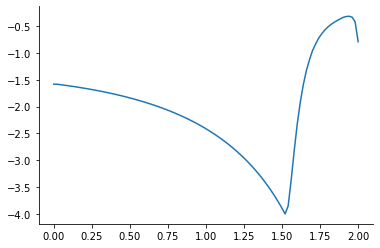

In [419]:
plt.plot(y_grid_short, model_res['v0_dy'])

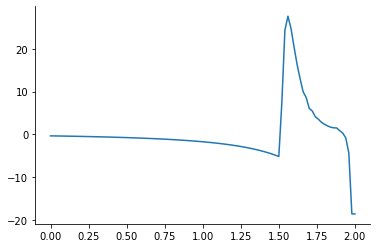

In [420]:
plt.plot(y_grid_short, model_res['v0_dyy'])

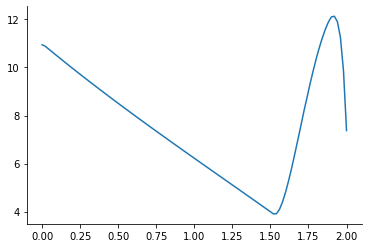

In [414]:
plt.plot(y_grid_short, model_res['e_tilde'])